## Лабораторная работа 8.

## Группа: РИМ-111060

## Подгруппа задания (вариант): 3

### ФИО студентов:
#### Лисовский Кирилл Алексеевич
#### Никитенко Андрей Михайлович
#### Уксусников Николай Алексеевич
#### Савин Михаил Валерьевич
#### Степаненко Дмитрий Владимирович

## 1. Сначала импортируйте в свой код нужные библиотеки, функции и т.д. Кроме того, произвести установки необходимых пакетов:


#### conda install graphviz
#### conda install pydot
#### conda install pydotplus
#### pip install keras --user
#### pip install tensorflow --user
#### pip install pydot-ng
#### pip install pydot

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pydot_ng as pydot
import numpy.random as rand
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential # здесь необходимо установить модули командами
from keras.layers import Dense # pip install keras --user
from keras.layers import LSTM # pip install tensorflow --user
from keras.layers import Dropout

## 2. Загрузите из mat-файла Fort.mat ряд, содержащий отсчеты некоторого реального ВР, всего 174 отсчета в вектор-строке, и отмасштабируйте его в диапазон от 0 до 1, так как функция активации слоя LSTM корректно обрабатывает значения только в данном диапазоне:

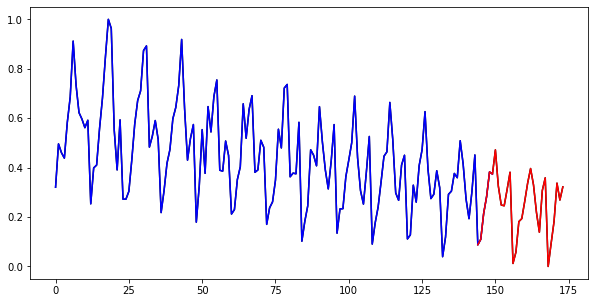

In [53]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
F = Fort
scaler = MinMaxScaler(feature_range=(0, 1)) # подгоняет под масштаб по оси OY от 0 до 1
F = scaler.fit_transform(F) # так как функция активации слоя LSTM корректно обрабатывает значения только в данном диапазоне
F_tr = F[:150]
F_test = F[144:]
plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:150],F_tr, 'b')
plt.plot(np.r_[144:174],F_test, 'r')
plt.show()

## 3. Важно произвести предобработку исходных данных в формат, понимаемый слоем LSTM-сети, в виде «порций» (batches) для обучения/валидации:

In [54]:
from keras.preprocessing.sequence import TimeseriesGenerator
data_gen = TimeseriesGenerator(F_tr, F_tr, length=6, sampling_rate=1, batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # 144 точки обучения, прогноз 1 точки по 6 прошлым
xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # меняем местами размерности
print(yy.shape)

(144, 6, 1)
(144, 1, 6)
(144, 1)


## 4. Затем составляется сама модель прогнозной сети. В простейшем случае нам понадобится только 1 внутренний LSTM-слой и 1 выходной слой. Тогда модель строится как:

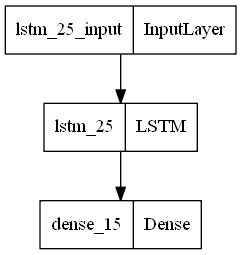

In [55]:
from keras.utils.vis_utils import plot_model
model = Sequential() # слои соединены последовательно
model.add(LSTM(units=20, input_shape=(1, 6))) # 20 нейронов
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png') # рисунок полученной сети

### Но слои LSTM замечательны тем, что могут иметь связи между собой кроме стандартных входов-выходов для реализации «долгой памяти». В этом случае в коде модели необходимо это указывать. Также в такие модели зачастую добавляют слои “Dropout”, которые со случайной заданной вероятностью обнуляют входы следующего слоя при обучении, тем самым позволяя избежать переобучения всей нейронной сети в целом.

### Например, модель из 3 слоев LSTM может быть построена примерно следующим образом:

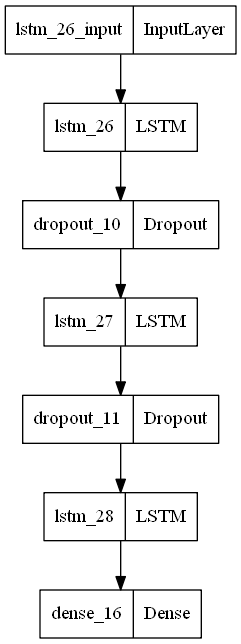

In [56]:
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(1, 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png')

## 5. В качестве функции оптимизации здесь задан алгоритм Adam.

### Adam — adaptive moment estimation, оптимизационный алгоритм, который сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков. Отличительная особенность в том, что функция использует сглаженные версии среднего и среднеквадратичного градиента. Алгоритм используется для градиентной оптимизации стохастических целевых функций первого порядка, основанный на адаптивных оценках моментов более низкого порядка. Данный способ хорошо подходит для нестационарных целей и задач с очень шумными и / или разреженными градиентами. Во время процедуры обучения мы минимизируем ошибку между прогнозом и фактическими наблюдениями в терминах корня среднеквадратичной ошибки 'mean_squared_error'.

## 6. Наконец, производим обучение нашей модели:

In [57]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

Epoch 1/100
5/5 [==============================] - 3s 5ms/step - loss: 0.2294
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.2187
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.2077
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1967
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1724
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1586
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1422
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1259
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1075
Epoch 11/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0872
Epoch 12/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0712
Epoch 13/100
5/5 [==============================] - 0s 4ms/st

## 7. Чтобы посмотреть, что же у нас получилось обучить, построим ретроспективный прогноз, с переходом обратно к исходному масштабу данных:

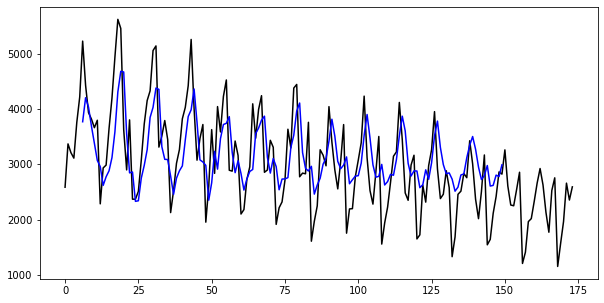

In [58]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()

## 8. А для тестовой проверки прогноза придется исходные точки вновь переработать в формат, понятный для модели LSTM-сети:

In [59]:
data_gen = TimeseriesGenerator(F_test, F_test, length=6, sampling_rate=1,batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0
xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # прогноз на 24 точки по 6 наблюдениям
print(yy.shape)

(24, 1, 6)
(24, 1)


## 9. Строим получившийся тестовый прогноз в нужном масштабе:

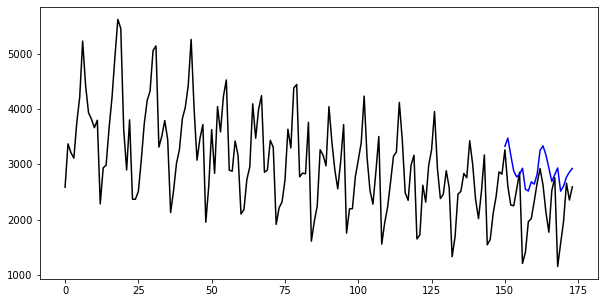

In [60]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()

## 10. Теперь самостоятельно попробуем подобрать такую модель и ее параметры (число нейронов в слоях, общая структура, коэффициенты Dropout, число предыдущих точек для прогноза, число наблюдений для обучения и т.д.), чтобы получить наиболее удачный результат. Длина прогноза должна быть в 24 отсчета.

### Графики исходного ряда Fort и прогноза строятся вместе, так как они имеют малую длину и вполне могут поместиться рядом с достаточной точностью.

In [61]:
F_test = F[138:]

data_gen = TimeseriesGenerator(F_tr, F_tr, length=12, sampling_rate=1, batch_size=150)
batch_0 = data_gen[0]

x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # 138 точек обучения, прогноз 1 точки по 12 прошлым точкам

xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y

print(xx.shape) # меняем местами размерности
print(yy.shape) #

model = Sequential() # слои соединены последовательно
model.add(LSTM(units=70, input_shape=(1, 12))) # 70 нейронов
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model = Sequential()
model.add(LSTM(units=70, return_sequences=True, input_shape=(1, 12)))
model.add(Dropout(0.01))
model.add(LSTM(units=70, return_sequences=True))
model.add(Dropout(0.01))
model.add(LSTM(units=70))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(xx, yy, epochs = 80) # 80 эпох

data_gen = TimeseriesGenerator(F_test, F_test, length=12, sampling_rate=1,batch_size=150)
batch_0 = data_gen[0]
x, y = batch_0

xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y

print(xx.shape) # прогноз на 24 точки по 24 наблюдениям
print(yy.shape) 

(138, 12, 1)
(138, 1, 12)
(138, 1)
Epoch 1/80
5/5 [==============================] - 3s 6ms/step - loss: 0.2135
Epoch 2/80
5/5 [==============================] - 0s 5ms/step - loss: 0.1874
Epoch 3/80
5/5 [==============================] - 0s 4ms/step - loss: 0.1553
Epoch 4/80
5/5 [==============================] - 0s 4ms/step - loss: 0.1109
Epoch 5/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0609
Epoch 6/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0314
Epoch 7/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0382
Epoch 8/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0291
Epoch 9/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0281
Epoch 10/80
5/5 [==============================] - 0s 6ms/step - loss: 0.0288
Epoch 11/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0260
Epoch 12/80
5/5 [==============================] - 0s 4ms/step - loss: 0.0256
Epoch 13/80
5/5 [=====================

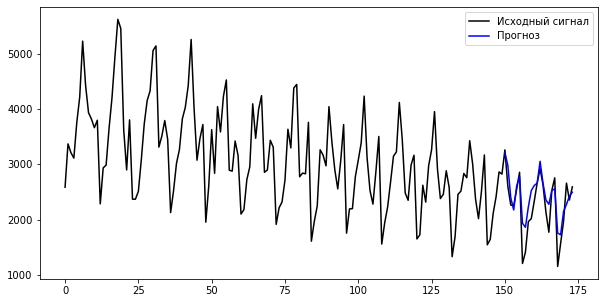

In [62]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k', label='Исходный сигнал')
plt.plot(np.r_[150:174],testPredict, 'b', label='Прогноз')
plt.legend()
plt.show()

## 11. Постройте прогноз на 256 точек для следующего модельного временного ряда и самостоятельно выберите для него параметры:

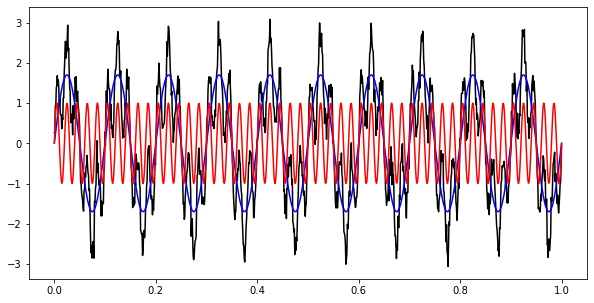

In [63]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50
F = 1.7*np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)+0.2*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, 1.7*np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

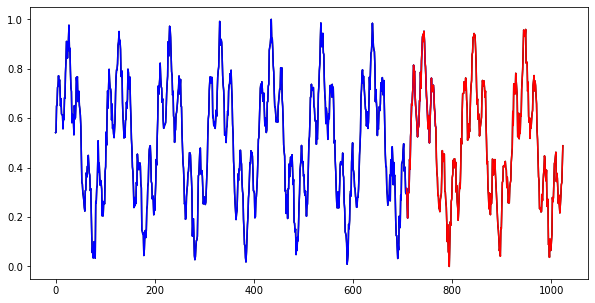

(708, 60, 1)
(708, 1, 60)
(708, 1)
Epoch 1/20
23/23 [==============================] - 4s 4ms/step - loss: 0.1967
Epoch 2/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 3/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 4/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 6/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 8/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 9/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 10/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 11/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 12/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 13/20
23

In [64]:
F_ras = np.array(F) # переводим исходный массив F в расчетный массив F_ras
F_ras = F_ras.reshape(-1, 1) # делаем из одномерного масства двумерный

PR_T = 256 # Количество прогнозируемых точек
PR_past = 60 #  по скольким предыдущим точкам проводим обучение
neir = 50 # Количество нейронов в цепочке
pogr = 0.01 # Допустимое отклонение 
epo = 20 # Количество эпох

scaler = MinMaxScaler(feature_range=(0, 1)) # подгоняет под масштаб по оси OY от 0 до 1
F_ras = scaler.fit_transform(F_ras) # так как функция активации слоя LSTM корректно обрабатывает значения только в данном диапазоне
F_tr = F_ras[:len(F_ras)-PR_T]
F_test = F_ras[len(F_ras)-PR_T-PR_past:]
plt.figure(figsize = (10, 5))
plt.plot(F_ras, 'k')
plt.plot(np.r_[:len(F_ras)-PR_T],F_tr, 'b')
plt.plot(np.r_[len(F_ras)-PR_T-PR_past:len(F_ras)],F_test, 'r')
plt.show()

data_gen = TimeseriesGenerator(F_tr, F_tr, length=PR_past, sampling_rate=1, batch_size=len(F_ras)-PR_T)
batch_0 = data_gen[0]
x, y = batch_0 
print(x.shape)
xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape)
print(yy.shape)

model = Sequential() # слои соединены последовательно
model.add(LSTM(units=neir, input_shape=(1, 60)))
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model = Sequential()
model.add(LSTM(units=neir, return_sequences=True, input_shape=(1, 60)))
model.add(Dropout(pogr))
model.add(LSTM(units=neir, return_sequences=True))
model.add(Dropout(pogr))
model.add(LSTM(units=neir))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(xx, yy, epochs = epo)

data_gen = TimeseriesGenerator(F_test, F_test, length=PR_past, sampling_rate=1,batch_size=len(F_ras)-PR_T)
batch_0 = data_gen[0]
x, y = batch_0
xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # прогноз на 256 точек по 60 наблюдениям
print(yy.shape)

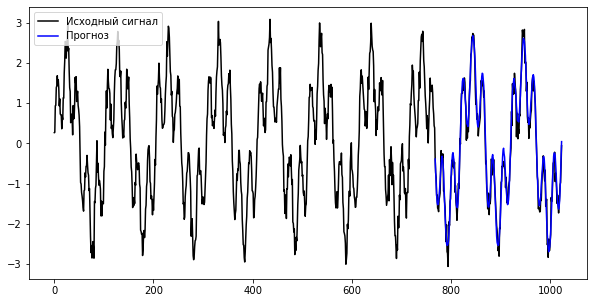

In [65]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(F, 'k',label='Исходный сигнал')
plt.plot(np.r_[len(F_ras)-PR_T:len(F_ras)],testPredict, 'b',label='Прогноз')
plt.legend()
plt.show()

## 12. Постройте прогноз на 256 точек для следующего модельного временного ряда и самостоятельно выберите для него параметры:

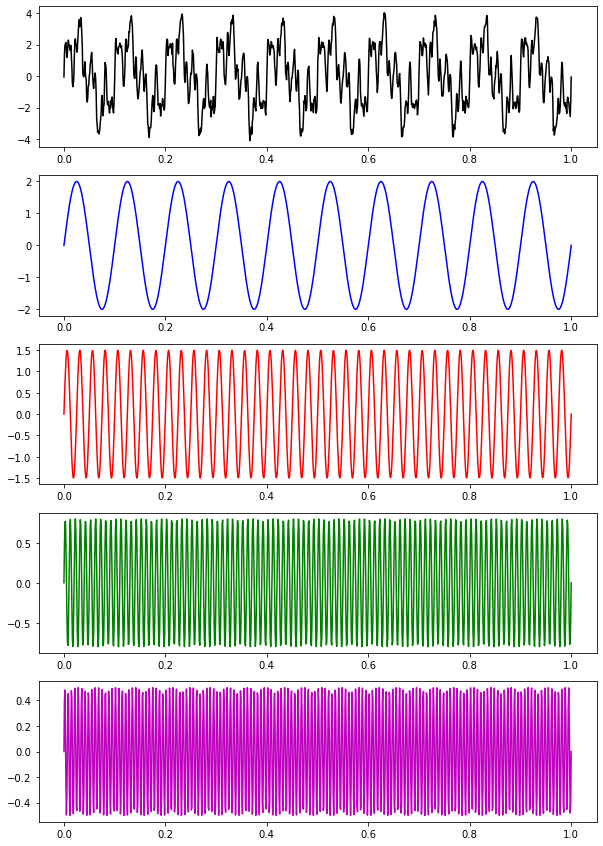

In [66]:
t = np.linspace(0,1,1024)
f1 = 10
f2 = 40
f3 = 100
f4 = 150
F = 2.0*np.sin(2*np.pi*f1*t)+1.5*np.sin(2*np.pi*f2*t)+0.8*np.sin(2*np.pi*f3*t)+0.5*np.sin(2*np.pi*f4*t)+0.2*rand.randn(len(t))
plt.figure(figsize = (10, 15))
plt.subplot(5,1,1)
plt.plot(t, F, 'k')
plt.subplot(5,1,2)
plt.plot(t, 2.0*np.sin(2*np.pi*f1*t), 'b')
plt.subplot(5,1,3)
plt.plot(t, 1.5*np.sin(2*np.pi*f2*t), 'r')
plt.subplot(5,1,4)
plt.plot(t, 0.8*np.sin(2*np.pi*f3*t), 'g')
plt.subplot(5,1,5)
plt.plot(t, 0.5*np.sin(2*np.pi*f4*t), 'm')
plt.show()

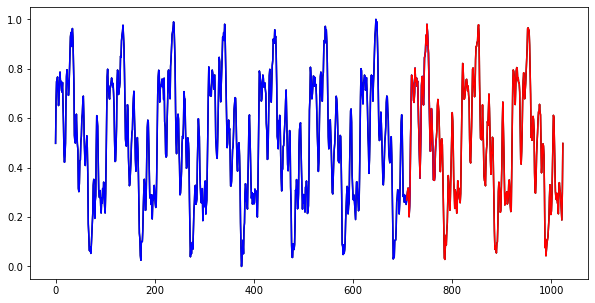

(708, 60, 1)
(708, 1, 60)
(708, 1)
Epoch 1/10
23/23 [==============================] - 4s 3ms/step - loss: 0.2685
Epoch 2/10
23/23 [==============================] - 0s 3ms/step - loss: 0.1299
Epoch 3/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 4/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0532
Epoch 5/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0372
Epoch 6/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 7/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 8/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 9/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 10/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0065
(256, 1, 60)
(256, 1)


In [67]:
F_ras = np.array(F) # переводим исходный массив F в расчетный массив F_ras
F_ras = F_ras.reshape(-1, 1) # делаем из одномерного масства двумерный

PR_T = 256 # Количество прогнозируемых точек
PR_past = 60 #  по скольким предыдущим точкам проводим обучение
neir = 20 # Количество нейронов в цепочке
pogr = 0.1 # Допустимое отклонение 
epo = 10 # Количество эпох

scaler = MinMaxScaler(feature_range=(0, 1)) # подгоняет под масштаб по оси OY от 0 до 1
F_ras = scaler.fit_transform(F_ras) # так как функция активации слоя LSTM корректно обрабатывает значения только в данном диапазоне
F_tr = F_ras[:len(F_ras)-PR_T]
F_test = F_ras[len(F_ras)-PR_T-PR_past:]
plt.figure(figsize = (10, 5))
plt.plot(F_ras, 'k')
plt.plot(np.r_[:len(F_ras)-PR_T],F_tr, 'b')
plt.plot(np.r_[len(F_ras)-PR_T-PR_past:len(F_ras)],F_test, 'r')
plt.show()

data_gen = TimeseriesGenerator(F_tr, F_tr, length=PR_past, sampling_rate=1, batch_size=len(F_ras)-PR_T)
batch_0 = data_gen[0]
x, y = batch_0 
print(x.shape) 
xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # меняем местами размерности
print(yy.shape) #

model = Sequential() # слои соединены последовательно
model.add(LSTM(units=neir, input_shape=(1, PR_past)))
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model = Sequential()
model.add(LSTM(units=neir, return_sequences=True, input_shape=(1, PR_past)))
model.add(Dropout(pogr))
model.add(LSTM(units=neir, return_sequences=True))
model.add(Dropout(pogr))
model.add(LSTM(units=neir))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(xx, yy, epochs = epo)

data_gen = TimeseriesGenerator(F_test, F_test, length=PR_past, sampling_rate=1,batch_size=len(F_ras)-PR_T)
batch_0 = data_gen[0]
x, y = batch_0
xx = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # прогноз на 256 точек по 60 наблюдениям
print(yy.shape)

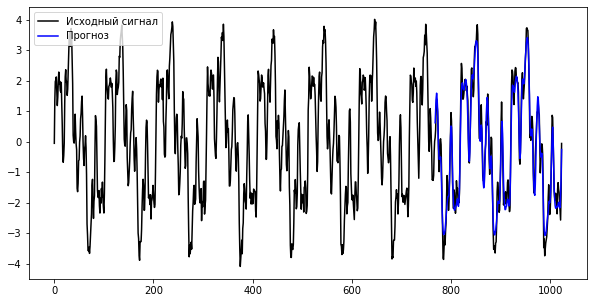

In [68]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(F, 'k',label='Исходный сигнал')
plt.plot(np.r_[len(F_ras)-PR_T:len(F_ras)],testPredict, 'b',label='Прогноз')
plt.legend()
plt.show()

## Выводы по работе

В ходе выполнения данной лабораторной работы были изучены подходы к рассмотрению модели LSTM как особой разновидности архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям. Вместо стандартных слоёв нейронных сетей данная сеть использует блоки ячеек. Эти ячейки имеют различные компоненты, называемые входным данными, выходными данными и компонентами памяти. В данной работе рассматривается реализация LSTM-прогнозной сети на основе фреймворка keras над tensorflow.

По итогам работы дана обобщённая оценка полученным результатам с учётом возможностей популярных python-библиотек.